# Final Project: Sentiment Analysis of Movie Reviews

# Introduction

This notebook represents the Data Science part of the sentiment analysis project. The objective is to develop a model capable of classifying movie reviews into negative or positive sentiments with an accuracy of 0.85 or higher. The model identified as the best in this notebook will form the foundation of a standalone application, which will be containerized using Docker.

For clarity: In this notebook (and the entire project), the terms "tokens", "features", and "words" are used interchangeably, as are "review/document" and "target/sentiment" or "corpus/dataset". It is also important to note that the terms "validation subset" and "test subset" refer to the same subset in this context.

# Importing Libraries and Training Dataset

In [1]:
import re
import time
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [2]:
df = pd.read_csv('../data/raw/train/train.csv')

# Auxiliary Methods

In [3]:
# Method is to obtain decriptive statistics on the dataset in terms of min, max, average, and frequencies for each label
def analyze_reviews(data, preprocessed=False, most_common=20, least_common=None, display_statistics=True):
    if not preprocessed:
        tokens_list = data['review'].apply(word_tokenize).tolist()
    else:
        tokens_list = data['review'].str.split().tolist()
    all_tokens = [token for sublist in tokens_list for token in sublist]
    total_unique_features = len(set(all_tokens))
    word_counts = [len(tokens) for tokens in tokens_list]
    min_features = min(word_counts)
    max_features = max(word_counts)
    avg_features = sum(word_counts) / len(word_counts)
    median_features = sorted(word_counts)[len(word_counts) // 2]
    doc_frequency = defaultdict(int)
    for tokens in tokens_list:
        unique_tokens = set(tokens)
        for token in unique_tokens:
            doc_frequency[token] += 1
    unique_in_one_document = sum(1 for word in doc_frequency if doc_frequency[word] == 1)

    if display_statistics:
      print(f"Total Unique Features: {total_unique_features}")
      print(f"Min Number of Features: {min_features}, Max Number of Features: {max_features}")
      print(f"Average Number of Features: {avg_features:.2f}, Median Number of Features: {median_features}")
      print(f"Number of features that appear in only one document: {unique_in_one_document}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    colors = {'positive': 'green', 'negative': 'red'}
    for i, label in enumerate(['positive', 'negative']):
        label_tokens = [token for j, tokens in enumerate(tokens_list) if data['sentiment'].iloc[j] == label for token in tokens]
        freq_dist = FreqDist(label_tokens)
        common_words = freq_dist.most_common(most_common)
        words, counts = zip(*common_words)
        axes[i].bar(words, counts, color=colors[label])
        axes[i].set_title(f"{most_common} Most Common Features in {label.capitalize()} Reviews")
        axes[i].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

    if least_common:
        least_common_words_df = pd.DataFrame()
        for label in ['positive', 'negative']:
            label_tokens = [token for j, tokens in enumerate(tokens_list) if data['sentiment'].iloc[j] == label for token in tokens]
            freq_dist = FreqDist(label_tokens)
            least_common_words = freq_dist.most_common()[:-least_common-1:-1]
            least_common_words_df[label] = [word for word, count in least_common_words]
        print(f"\n{least_common} Least Common Words in Each Class:")
        display(least_common_words_df)

In [4]:
# Method to plot preprocessed (but not vectorized) data to compare stemming and lemmatization
def plot_clean_data(data, use_lemmatization=False, row_number = 9):
    start_time = time.time()
    preprocessor = TextPreprocessor(use_lemmatization=use_lemmatization, vectorization_type=None)
    X, y, _ = preprocessor.preprocess(data)
    elapsed_time = time.time() - start_time
    preprocessed_df = pd.DataFrame({'review': X, 'sentiment': y.map({0: 'negative', 1: 'positive'})})
    print(f"Time taken for preprocessing: {elapsed_time:.2f} seconds")
    analyze_reviews(preprocessed_df, most_common=30, preprocessed=True)
    reviews_df = pd.DataFrame({
        "Original Review": [data['review'].iloc[row_number]],
        "Cleaned Review": [preprocessed_df['review'].iloc[row_number]]
    })
    return reviews_df.style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

In [5]:
# Method to process data in four different ways
def prepare_datasets(data_train, data_test):
    combinations = [
        (True, "ngrams"),
        (False, "ngrams"),
        (True, "tf-idf"),
        (False, "tf-idf")
    ]
    results = {}
    for use_lemmatization, vectorization_type in combinations:
        start_time = time.time()
        preprocessor = TextPreprocessor(use_lemmatization=use_lemmatization, vectorization_type=vectorization_type)
        X_train, y_train, vectorizer = preprocessor.preprocess(data_train, fit_vectorizer=True)
        X_test, y_test, _ = preprocessor.preprocess(data_test, fit_vectorizer=False)
        elapsed_time = time.time() - start_time
        key = f"Lemmatization={use_lemmatization}, Vectorization={vectorization_type}"
        results[key] = {
            "time_taken": elapsed_time,
            "train_shape": X_train.shape,
            "test_shape": X_test.shape,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            "vectorizer": vectorizer
        }
    return results

In [6]:
# Method to extract processed data
def extract_prepared_data(prepared_data, lemmatization, vectorization):
    base_key = f'Lemmatization={lemmatization}, Vectorization={vectorization}'
    data_dict = prepared_data[base_key]
    return (data_dict['X_train'], data_dict['y_train'], 
            data_dict['X_test'], data_dict['y_test'], data_dict['vectorizer'])

In [7]:
# Method to obtain most common words in vectorized data for each label
def plot_vectorized_data(X, y, vectorizer, top_n=30):
    X = X.tocsc() if not isinstance(X, np.ndarray) else X
    classes = [(1, 'green', 'Positive Class'), (0, 'red', 'Negative Class')]
    feature_names = vectorizer.get_feature_names_out()
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    for idx, (class_label, color, title) in enumerate(classes):
        class_data = X[y == class_label]
        sum_words_class = class_data.sum(axis=0)
        top_words_class = sorted([(feature_names[i], sum_words_class[0, i]) for i in range(class_data.shape[1])], 
                                 key=lambda x: x[1], reverse=True)[:top_n]
        axes[idx].bar([word[0] for word in top_words_class], [word[1] for word in top_words_class], color=color)
        axes[idx].set_title(f'Top 30 Most Common/Important Features in {title}')
        axes[idx].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

In [8]:
# Method to obtain most common bigrams and trigrams for each label
def top_bigrams_trigrams(X, y, vectorizer, top_n=5):
    def filter_ngrams(feature_names, n):
        return [f for f in feature_names if len(f.split()) == n]

    def top_ngrams(class_data, n):
        sum_words = class_data.sum(axis=0) 
        ngrams = filter_ngrams(feature_names, n)
        ngrams_idx = [vectorizer.vocabulary_.get(ng) for ng in ngrams]
        ngrams_freq = {ngrams[i]: sum_words[0, idx] for i, idx in enumerate(ngrams_idx) if idx is not None}
        sorted_ngrams = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
        return [ng[0] for ng in sorted_ngrams]
    
    X = X.tocsc() if not isinstance(X, np.ndarray) else X
    feature_names = vectorizer.get_feature_names_out()
    top_ngrams_df = pd.DataFrame(columns=['Class', 'Bigrams', 'Trigrams'])
    for class_label in [1, 0]:
        class_data = X[y == class_label]
        class_name = 'Positive' if class_label == 1 else 'Negative'
        top_bigrams = top_ngrams(class_data, 2)
        top_trigrams = top_ngrams(class_data, 3)
        top_ngrams_df = top_ngrams_df.append({'Class': class_name, 
                                              'Bigrams': ', '.join(top_bigrams), 
                                              'Trigrams': ', '.join(top_trigrams)}, 
                                             ignore_index=True)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)    
    return top_ngrams_df

In [9]:
# Method to streamline training and evaluation over four different datasets
def train_and_evaluate_model(model, datasets=None, X_train=None, y_train=None, X_test=None, y_test=None):
    results = {}
    if datasets:
        for key, data in datasets.items():
            X_train, y_train, X_test, y_test = data['X_train'], data['y_train'], data['X_test'], data['y_test']
            results[key] = run_model(model, X_train, y_train, X_test, y_test)
    else:
        if None in (X_train, y_train, X_test, y_test):
            raise ValueError("When not using datasets dictionary, all individual train-test sets must be provided.")
        key = "Custom Train-Test Set"
        results[key] = run_model(model, X_train, y_train, X_test, y_test)
    return results

# Method to train and evaluate a model on a dataset
def run_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {
        "train_time": train_time,
        "train_accuracy": model.score(X_train, y_train),
        "test_accuracy": accuracy,
        "test_f1": f1
    }

In [10]:
# Method to tune hyperparameters using gridsearch
def perform_gridsearch(model, param_grid, X_train, y_train, X_test, y_test):
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    best_index = grid_search.best_index_
    for i in range(5):
        fold_accuracy = grid_search.cv_results_[f'split{i}_test_score'][best_index]
        print(f"Accuracy for fold {i+1}: {fold_accuracy:.4f}")
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1_score = f1_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    try:
        test_aucroc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
    except AttributeError:
        test_aucroc = roc_auc_score(y_test, grid_search.decision_function(X_test))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
    print(f"Test AUC ROC score: {test_aucroc:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [11]:
# Method to plot top n features for a given model
def plot_feature_importances(model, vectorizer, top_n=20):
    is_linear_model = hasattr(model, 'coef_')
    if is_linear_model:
        importances = model.coef_.ravel()
        # For linear models, we can have both positive and negative features
        top_positive_indices = np.argsort(importances)[-top_n:][::-1]
        top_negative_indices = np.argsort(importances)[:top_n]
        top_indices = np.hstack([top_positive_indices, top_negative_indices[::-1]])
        title = f'Top {top_n} Positive and Negative Feature Importances in the Linear Model'
    else:
        importances = model.feature_importances_
        # For tree-based models, only positive features are relevant
        top_indices = np.argsort(importances)[-top_n:][::-1]
        title = f'Top {top_n} Feature Importances in the Tree-Based Model'
    top_features = vectorizer.get_feature_names_out()[top_indices]
    top_importances = importances[top_indices]
    plt.figure(figsize=(10, top_n/2))
    colors = ['green' if c > 0 else 'red' for c in top_importances] if is_linear_model else 'blue'
    plt.barh(np.arange(len(top_indices)), top_importances, color=colors)
    plt.yticks(np.arange(len(top_indices)), top_features)
    plt.xlabel('Importance Value' if not is_linear_model else 'Coefficient Value')
    plt.title(title)
    plt.axvline(x=0, color='k', linestyle='--') if is_linear_model else None
    plt.gca().invert_yaxis()
    plt.show()

# EDA

To start off, let's take a sneak peak at the raw dataset. In the notebook we will only be working with the training data (train.csv).

In [12]:
display(df.head(10), df.info(), df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
5,Opera (the U.S. title is terror at the opera) ...,positive
6,Heard about this film a long while ago and fin...,positive
7,"John Holmes is so famous, he's infamous (as th...",positive
8,What is worth mentioning that is omitted in th...,positive
9,Darling Lili is fantastic! Its by far one my f...,positive


None

review       0
sentiment    0
dtype: int64

The training dataset comprises 40,000 reviews, without missing values. The initial inspection of the dataset reveals special characters, contractions, and proper nouns, all of which should be addressed during data preprocessing to improve the quality of the analysis.

Let's check class distribution among the target labels.

In [13]:
df['sentiment'].value_counts()

positive    20000
negative    20000
Name: sentiment, dtype: int64

The reviews are equally split between positive and negative sentiments.

Next, let's check for duplicates.

In [14]:
df.duplicated().sum()

272

In [15]:
df.drop_duplicates(inplace=True)

We have eliminated 272 duplicate entries. This is a comparatively minor fraction of the data, so its removal is unlikely to significantly disrupt the balance between the target classes—even if all duplicates were from the same class.

Lastly, let's examine feature distribution in the corpus. We will check the total number of tokens, the range of feature occurrences per document, and identify both the most and least common words by sentiment. This analysis may uncover additional text cleaning requirements.

Total Unique Features: 172303
Min Number of Features: 9, Max Number of Features: 2911
Average Number of Features: 279.82, Median Number of Features: 209
Number of features that appear in only one document: 93648


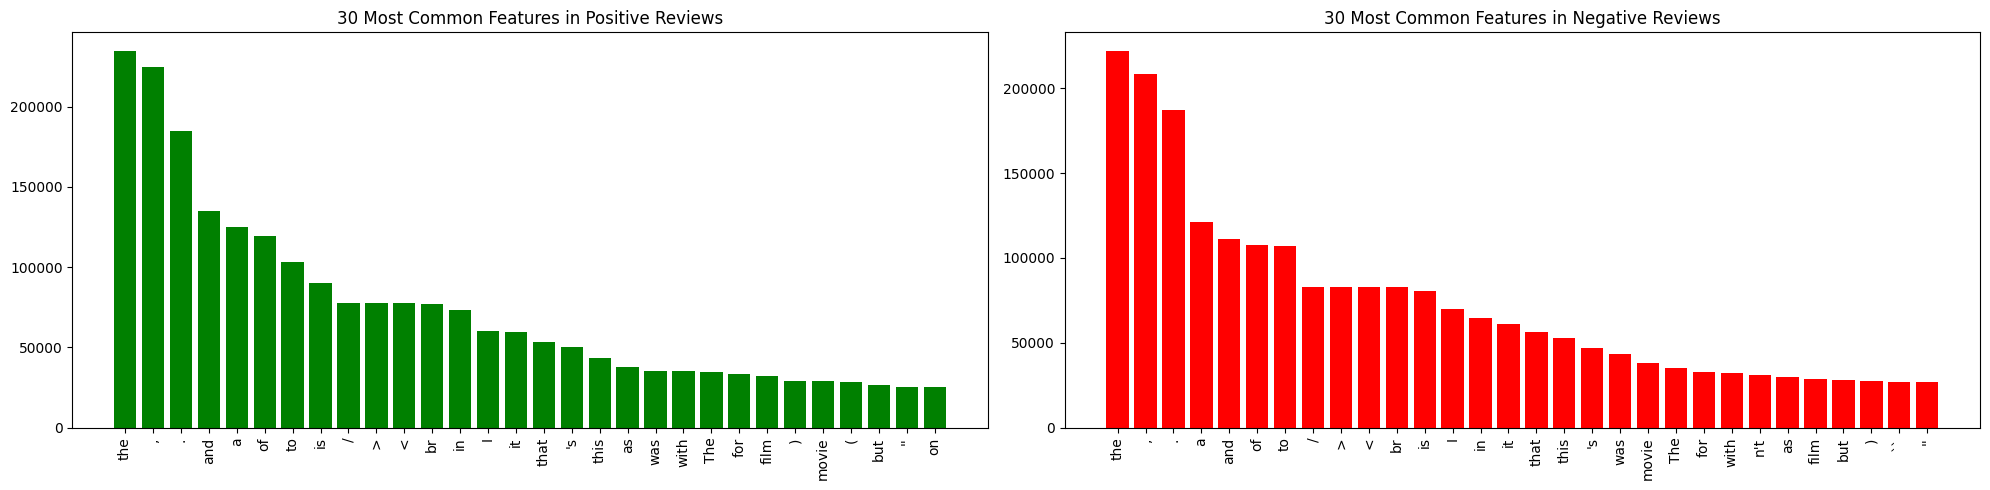


15 Least Common Words in Each Class:


,positive,negative
0,Morning.,crap.the
1,Whoo,with.it
2,Recommends,twins.
3,Criteria,hackneyed.
4,Late-Nineties,aggressive.
5,Farther,Sneakpreview
6,Gonsalves,whooshing
7,throw-caution-to-the-wind,Lookin
8,somberness,Hitched
9,less-than-honorable,Gettin


In [16]:
analyze_reviews(df, preprocessed=False, most_common=30, least_common=15)

* The corpus is saturated with special characters, HTML tags, and stop words that must be stripped to accurately isolate words indicative of positive or negative sentiments.
* The appearance of both "the" and "The" suggests a need for case normalization prior to stop word removal to ensure consistency.
* A significant proportion—over half—of the features are "least common," appearing only once in the corpus. This is largely attributed to the use of special characters and capitalization.
* The occurrence of unique words, such as 'obbsessed' and 'reecommend,' points to misspellings. Ideally, spell-checking should be applied to reduce unique features and enhance data quality. However, given the computational intensity of spell-checking, applying it to the entire dataset could be excessively time-consuming.

# Data Preprocessing

The raw train data will undergo the following preprocessing steps:

* Split into train and validation subsets using `test_size = 0.2`.
* Separate into `X` (reviews) and `y` (sentiment), with `y` numerically encoded (1 for positive, 0 for negative).
* Expand negating contractions (e.g., "didn't" to "did not") to maintain negation after stop word removal.
* Remove URLs, HTML tags, and contractions ('ve, 'd, 'll, 'm , etc.).
* Tokenize the text.
* Exclude proper nouns, special characters, and numbers.
* Convert all text to lowercase.
* Remove stop words, except for "not", using the English NLTK library. The word "not" is preserved in the corpus since it may be pointing at a negative sentiment (e.g. so that in a review saying "I did not enjoy this movie", the words "not", "enjoy" and "movie" would remain after removal of stop words).
* Exclude words with less than three characters.
* Eliminate rare words that appear only once in the training corpus. These words will be identified based on the train subset and removed from both subsets. It may make more sense to spell check those rare words first, but it will take several hours to do that since we have tens of thousands of rare words. 
* Apply stemming or lemmatization.
* Vectorize the text using either n-grams (including unigrams, bigrams, and trigrams) or TF-IDF. The vectorizer will be fitted on the train subset and applied to both subsets.

Eventually, four sets of train-test data will be prepared with varying parameters:
* Lemmatization with n-grams vectorization
* Lemmatization with TF-IDF vectorization
* Stemming with n-grams vectorization
* Stemming with TF-IDF vectorization

To evaluate the impact of stemming versus lemmatization and different vectorization methods, I will present dataset shapes, samples of preprocessed text, and compare these preprocessing approaches in terms of model performance and training duration during the modeling phase.

In [17]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

In [18]:
class TextPreprocessor:
    def __init__(self, use_lemmatization=True, vectorization_type=None):
        self.use_lemmatization = use_lemmatization
        self.vectorization_type = vectorization_type
        self.stop_words = set(stopwords.words('english')) - {'not'}
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if not use_lemmatization else None
        self.vectorizer = None
        self.rare_words = None
        self.contraction_mapping = {
            r"\bdidn't\b": "did not", r"\bdon't\b": "do not",
            r"\bwasn't\b": "was not", r"\bisn't\b": "is not",
            r"\bweren't\b": "were not", r"\bare't\b": "are not",
            r"\bwouldn't\b": "would not", r"\bwon't\b": "will not",
            r"\bcouldn't\b": "could not", r"\bcan't\b": "can not",
            r"\bain't\b": "am not", r"\bdoesn't\b": "does not",
            r"\bshouldn't\b": "should not", r"\bhadn't\b": "had not",
            r"\bhaven't\b": "have not", r"\bhasn't\b": "has not",
            r"\bmustn't\b": "must not"
        }

    def preprocess(self, data, fit_vectorizer=False):
        if 'sentiment' in data.columns:
            y = data['sentiment'].map({'negative': 0, 'positive': 1})
        else:
            y = None
        
        if self.rare_words is None:
            self._calculate_rare_words(data['review'])

        X_cleaned = data['review'].apply(self._clean_text)

        if self.vectorization_type and fit_vectorizer:
            self.vectorizer = self._get_vectorizer()
            X_vectorized = self.vectorizer.fit_transform(X_cleaned)
        elif self.vectorization_type:
            X_vectorized = self.vectorizer.transform(X_cleaned)
        else:
            X_vectorized = X_cleaned

        return X_vectorized, y, self.vectorizer if fit_vectorizer else None

    def _get_vectorizer(self):
        if self.vectorization_type.lower() == 'ngrams':
            return CountVectorizer(ngram_range=(1, 3), stop_words=list(self.stop_words))
        elif self.vectorization_type.lower() == 'tf-idf':
            return TfidfVectorizer(stop_words=list(self.stop_words))
        else:
            raise ValueError("Invalid vectorization type specified.")

    def _initial_preprocess(self, text):
        for contraction, expanded in self.contraction_mapping.items():
            text = re.sub(contraction, expanded, text, flags=re.IGNORECASE)
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"(n't|'d|'ll|'m|'re|'s|'ve|')", '', text, flags=re.IGNORECASE)
        tokens = word_tokenize(text)
        tokens = [word for word, pos in pos_tag(tokens) if pos not in ['NNP', 'NNPS']]
        tokens = [re.sub(r'\W+', ' ', word) for word in tokens if not word.isnumeric()]
        return [word.lower() for word in tokens]

    def _calculate_rare_words(self, reviews):
        all_words = [word for review in reviews for word in self._initial_preprocess(review)]
        word_counts = Counter(all_words)
        self.rare_words = {word for word, count in word_counts.items() if count == 1}

    def _clean_text(self, text):
        tokens = self._initial_preprocess(text)
        tokens = [word for word in tokens if word not in self.rare_words and word not in self.stop_words and len(word) > 2]

        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        else:
            tokens = [self.stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)

## Stemming vs Lemmatization

### Stemming

Time taken for preprocessing: 351.44 seconds
Total Unique Features: 20762
Min Number of Features: 1, Max Number of Features: 969
Average Number of Features: 103.53, Median Number of Features: 78
Number of features that appear in only one document: 694


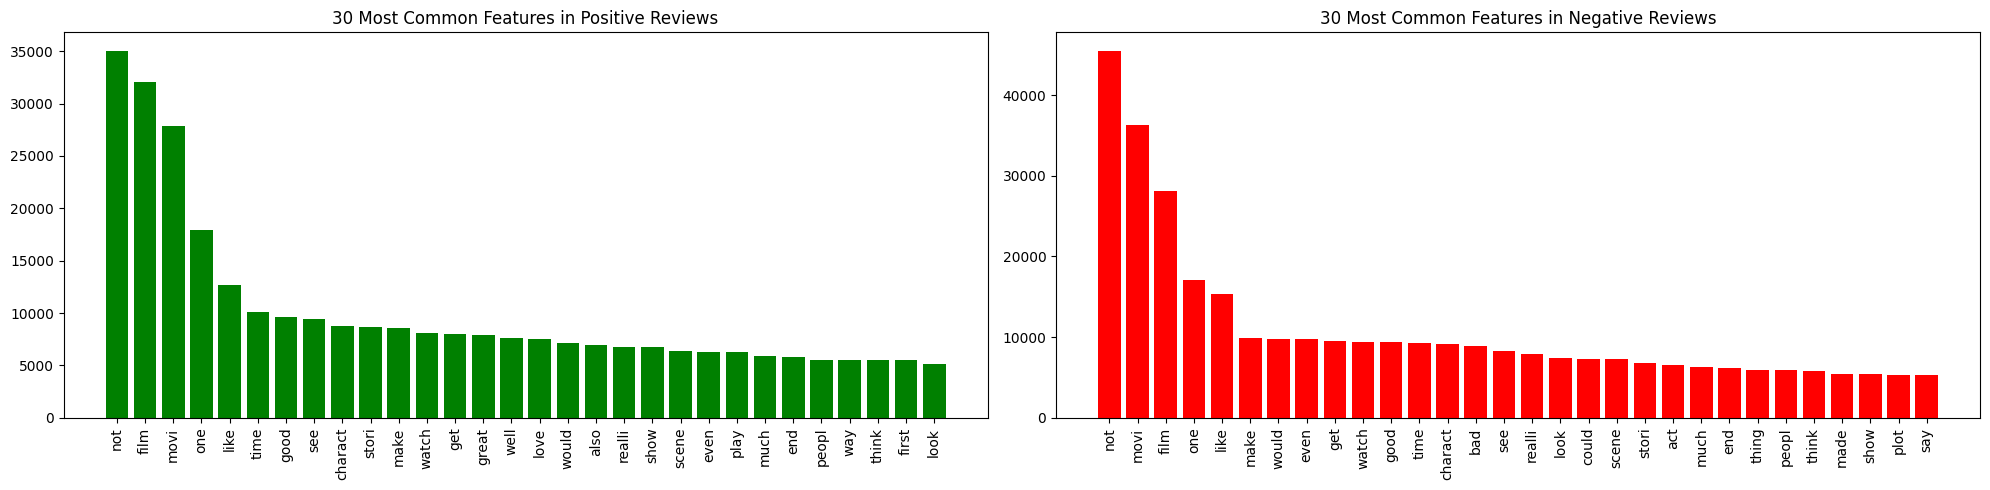

,Original Review,Cleaned Review
0,"I really love anything done by Savage Steve Holland, the writer/director of this great movie. Also see ""Better Off Dead"" and ""How I Got Into College."" Wonderful! Anyway this movie is really humorous and delivers some unexpected things. Where else but in this movie can you see Demi Moore as a talented singer and Bobcat Golthwait as a twin? I recommend this to anybody looking for some old fashioned slapstick comedy (George with the turtle raft), not to mention some really well written sarcasm (the Christmas tree on the roof of the car). This movie constantly throws you unexpected things even after you've seen it 100 times like I have! Enjoy!",realli love anyth done writer director great movi also see got wonder anyway movi realli humor deliv unexpect thing els movi see talent singer twin recommend anybodi look old fashion slapstick comedi turtl raft not mention realli well written sarcasm tree roof car movi constantli throw unexpect thing even seen time like enjoy


In [19]:
plot_clean_data(train, use_lemmatization=False, row_number=5)

### Lemmatization

Time taken for preprocessing: 324.47 seconds
Total Unique Features: 30853
Min Number of Features: 1, Max Number of Features: 969
Average Number of Features: 103.53, Median Number of Features: 78
Number of features that appear in only one document: 786


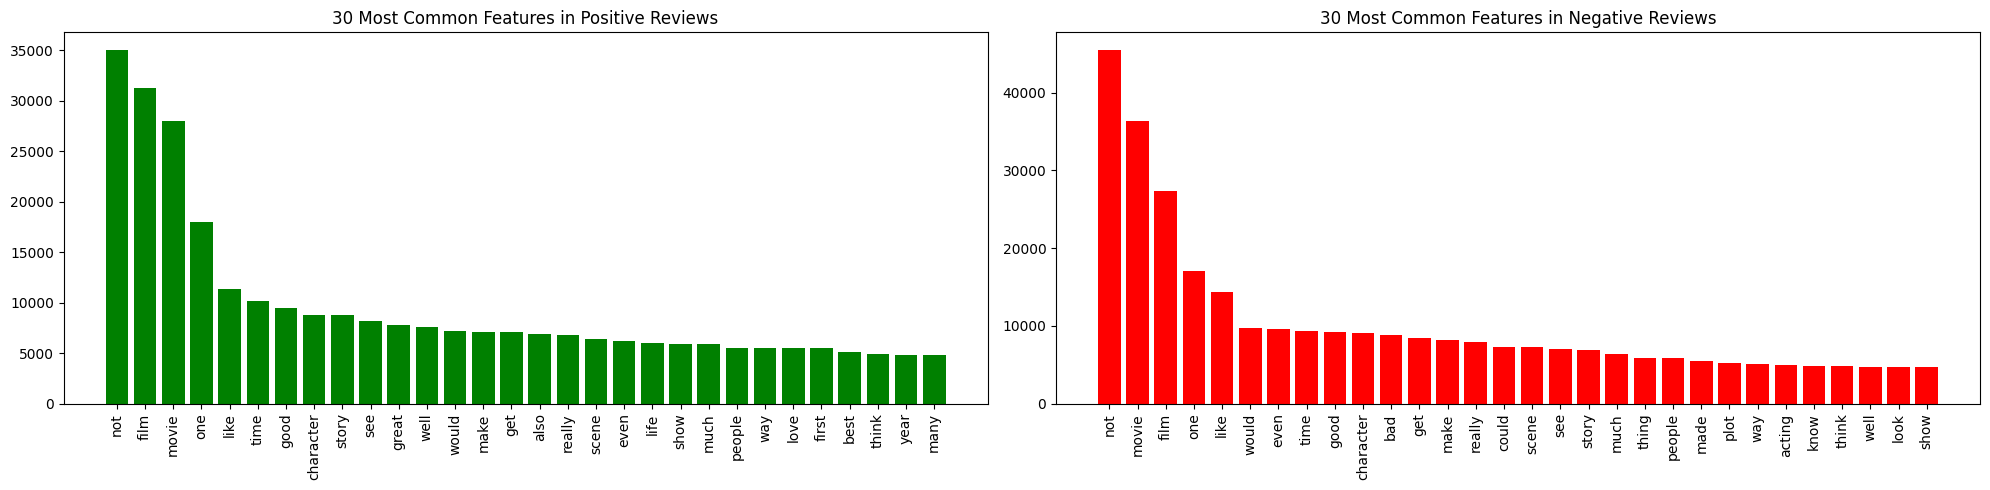

,Original Review,Cleaned Review
0,"I really love anything done by Savage Steve Holland, the writer/director of this great movie. Also see ""Better Off Dead"" and ""How I Got Into College."" Wonderful! Anyway this movie is really humorous and delivers some unexpected things. Where else but in this movie can you see Demi Moore as a talented singer and Bobcat Golthwait as a twin? I recommend this to anybody looking for some old fashioned slapstick comedy (George with the turtle raft), not to mention some really well written sarcasm (the Christmas tree on the roof of the car). This movie constantly throws you unexpected things even after you've seen it 100 times like I have! Enjoy!",really love anything done writer director great movie also see got wonderful anyway movie really humorous delivers unexpected thing else movie see talented singer twin recommend anybody looking old fashioned slapstick comedy turtle raft not mention really well written sarcasm tree roof car movie constantly throw unexpected thing even seen time like enjoy


In [20]:
plot_clean_data(train, use_lemmatization=True, row_number=5)

**General remarks:**
* The preprocessing significantly reduced the number of unique tokens, resulting in documents ranging from one to 969 tokens.
* Common features like "not", "movie", "film", "one", and "like" are prevalent in both negative and positive labels.
* Words typically regarded as stop words ("would", "could", "one", "get", "even") remain prominent in the corpus. These words are not included in the NLTK library.
* It may be beneficial to exclude words such as "movie" and "film" or expand the stop word list using the SpaCy library. Further exploration of these additional cleaning steps and their impact on model accuracy will be presented in the [Appendix](#appendix-1).

**Comparison of lemmatized and stemmed datasets:**
* The stemmed dataset has fewer features than the lemmatized one: 22,395 compared to 33,349. 
* Stemming required more processing time than lemmatization for the training data.
* The top 30 common words are similar between the datasets, with minor differences in order for words like "watch", "life", and "way".
* Stemming resulted in the creation of non-standard words (e.g., "stori", "charact", "realli"), which is a known characteristic of this technique.

## N-Grams vs TF-IDF

In [21]:
prepared_data = prepare_datasets(train, test)

for key, value in prepared_data.items():
    print(f"{key}: Time taken - {value['time_taken']:.2f} seconds, Train set shape - {value['train_shape']}, Test set shape - {value['test_shape']}")

Lemmatization=True, Vectorization=ngrams: Time taken - 380.23 seconds, Train set shape - (31782, 4575415), Test set shape - (7946, 4575415)
Lemmatization=False, Vectorization=ngrams: Time taken - 414.48 seconds, Train set shape - (31782, 4335322), Test set shape - (7946, 4335322)
Lemmatization=True, Vectorization=tf-idf: Time taken - 369.51 seconds, Train set shape - (31782, 30703), Test set shape - (7946, 30703)
Lemmatization=False, Vectorization=tf-idf: Time taken - 401.97 seconds, Train set shape - (31782, 20616), Test set shape - (7946, 20616)


* Preprocessing Duration: Vectorizing with n-grams took slightly longer than using TF-IDF. Additionally, this observation confirms that preprocessing with stemming is more time-consuming than with lemmatization.
* Data Shape: The use of n-grams vectorization, ranging from unigrams to trigrams, significantly increased the dimensionality of the datasets. In contrast, TF-IDF vectorization did not alter the size of either the lemmatized or stemmed datasets.
* Consistency Across Train and Test Sets: Both the train and validation (test) sets align in terms of column numbers. This alignment is likely due to vectorization standardizing the features, ensuring that the features used in training are consistently applied to the test set.

Next, I will examine how the distribution of the most common or important words varies between the two vectorization methods. For this analysis, I will use the lemmatized datasets to isolate the effects of the vectorization techniques.

In [22]:
X_train_lemma_ngrams, y_train_lemma_ngrams, X_test_lemma_ngrams, y_test_lemma_ngrams, vectorizer_lemma_ngrams = extract_prepared_data(prepared_data, True, 'ngrams')
X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf, vectorizer_lemma_tfidf = extract_prepared_data(prepared_data, True, 'tf-idf')
X_train_stem_ngrams, y_train_stem_ngrams, X_test_stem_ngrams, y_test_stem_ngrams, vectorizer_stem_ngrams = extract_prepared_data(prepared_data, False, 'ngrams')
X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf, vectorizer_stem_tfidf = extract_prepared_data(prepared_data, False, 'tf-idf')

### N-Grams

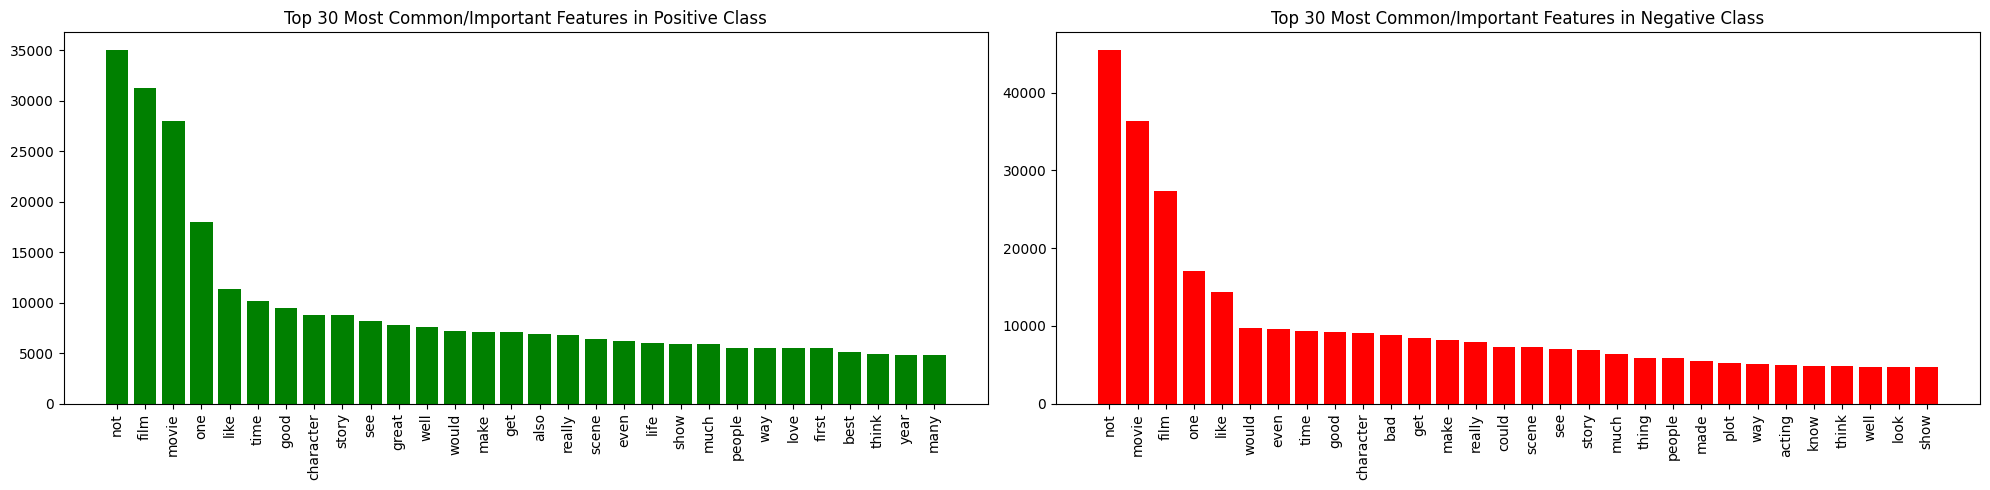

In [23]:
plot_vectorized_data(X_train_lemma_ngrams, y_train_lemma_ngrams, vectorizer_lemma_ngrams)

* The analysis indicates that n-grams vectorization did not change the distribution of frequent features in the lemmatized dataset. Despite including bigrams and trigrams in the range, the most common features observed in the plot are predominantly unigrams.
* To gain a deeper understanding of the impact of n-grams vectorization, let's explore the most common 5 bigrams and trigrams for each class. This examination will reveal if and how word combinations and phrases contribute differently to each sentiment class.

In [24]:
top_bigrams_trigrams(X_train_lemma_ngrams, y_train_lemma_ngrams, vectorizer_lemma_ngrams)

,Class,Bigrams,Trigrams
0,Positive,"movie not, film not, one best, not know, could not","movie ever seen, one best movie, film ever made, one best film, best movie ever"
1,Negative,"not even, movie not, could not, look like, film not","worst movie ever, movie ever seen, not waste time, worst film ever, one worst movie"


While the significance of bigrams is not immediately apparent, the analysis of trigrams reveals distinct patterns that align with each sentiment class. For instance, trigrams like 'best movie ever' frequently occur in positive reviews, while 'worst movie ever' is commonly found in negative reviews. This observation highlights the utility of including trigrams in the analysis, as they can capture more nuanced expressions of sentiment.

### TF-IDF

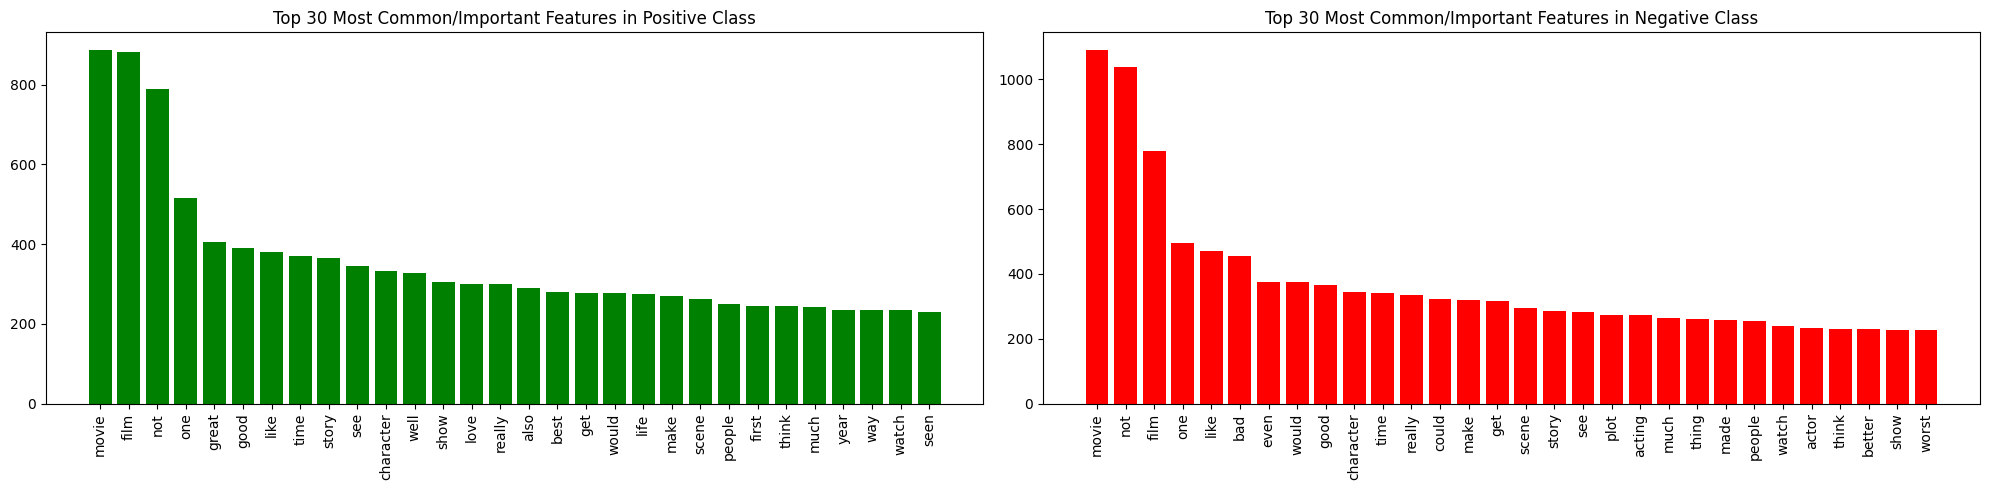

In [25]:
plot_vectorized_data(X_train_lemma_tfidf, y_train_lemma_tfidf, vectorizer_lemma_tfidf)

* The plot clearly demonstrates that the distribution of the most common words varies when using TF-IDF vectorization compared to n-grams.
* Notably, the y-axis scale, representing frequency, differs between the two vectorization methods. For n-grams, frequencies are counted in thousands, while for TF-IDF, they are in hundreds.
* This difference arises because TF-IDF not only accounts for the frequency of terms (TF) but also adjusts this frequency based on the term's distribution across the entire corpus (IDF). The scores generated by TF-IDF range from 0 to 1, reflecting a term's weighted frequency that considers both its local significance in individual documents and its overall rarity in the corpus. The bar chart aggregates these TF-IDF scores for each term across all documents, with the resultant values representing weighted frequencies rather than probabilities.

# Modeling

Modeling will be performed with four traditional machine learning algorithms:
* LinearSVC, a streamlined version of the SVC algorithm. It offers faster training times compared to the original SVC with a linear kernel, which is advantageous for large datasets like ours.
* Logistic Regression. While a deep learning approach would be ideal for logistic regression, it demands extensive computational resources, which are beyond the current project's capacity.
* Random Forest, selected over a Decision Tree to mitigate the risk of overfitting.
* CatBoost, known for its effectiveness with categorical features and minimal hyperparameter tuning requirements.

These algorithms were chosen based on their proven performance in previous classification tasks, where they outperformed alternatives like KNN, Naive Bayes, or Decision Trees.  

The four models will each be trained on four datasets, resulting in 16 baseline models. This approach allows for a comprehensive comparison of lemmatization, stemming, and both vectorization techniques. In these baseline models, only the random state will be set, with `max_iter` increased to 5000 for Logistic Regression and LinearSVC to ensure convergence. The feasibility of hyperparameter tuning will depend on the training duration of the baseline models. If the target accuracy is not achieved, further tuning will be considered. Models will be evaluated based on validation accuracies, F1 scores, and training times.

## Linear SVC

In [26]:
linear_svc_results = train_and_evaluate_model(LinearSVC(random_state=42, max_iter=5000), datasets=prepared_data)

for key, value in linear_svc_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, " 
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

Set: Lemmatization=True, Vectorization=ngrams, Training Time: 6.71 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8903, Test F1 Score: 0.8920
Set: Lemmatization=False, Vectorization=ngrams, Training Time: 7.46 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8875, Test F1 Score: 0.8892
Set: Lemmatization=True, Vectorization=tf-idf, Training Time: 0.22 seconds, Train Accuracy: 0.9729, Test Accuracy: 0.8806, Test F1 Score: 0.8821
Set: Lemmatization=False, Vectorization=tf-idf, Training Time: 0.22 seconds, Train Accuracy: 0.9597, Test Accuracy: 0.8799, Test F1 Score: 0.8818


* The dataset with the highest dimensionality, which was lemmatized and vectorized using n-grams, achieved the highest accuracy and F1 score. However, this came with a trade-off in training time, as n-grams vectorization led to considerably longer training durations compared to other methods. 
* Overall, models trained on lemmatized datasets outperformed those trained on stemmed datasets.
* Using n-grams for vectorization consistently yielded better results than TF-IDF. The choice of vectorization technique appears to have a more significant impact on model performance than the distinction between lemmatization and stemming.

Given that training times were only a few seconds at most, I will proceed with hyperparameter tuning for the most promising model. The goal is to further enhance performance on the dataset that yielded the best results. For the LinearSVC algorithm in a binary classification task, I will focus on tuning the following hyperparameters:
* Regularization parameter, `C`: A lower value implies more regularization. The default value is 1.0.
* Loss function, `loss`: The default value is `squared_hinge`.

In [27]:
def linear_svc_gridsearch(X_train, y_train, X_test, y_test):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1],
        'loss': ['hinge', 'squared_hinge']
    }
    linear_svc = LinearSVC(random_state=42, max_iter=5000)
    perform_gridsearch(linear_svc, param_grid, X_train, y_train, X_test, y_test)

In [28]:
linear_svc_gridsearch(X_train_lemma_ngrams, y_train_lemma_ngrams, X_test_lemma_ngrams, y_test_lemma_ngrams)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 0.01, 'loss': 'squared_hinge'}
Best cross-validation accuracy: 0.8891
Accuracy for fold 1: 0.8902
Accuracy for fold 2: 0.8806
Accuracy for fold 3: 0.8960
Accuracy for fold 4: 0.8845
Accuracy for fold 5: 0.8940
Test Accuracy: 0.8928, Test F1 Score: 0.8946
Test Precision: 0.8824, Test Recall: 0.9072
Test AUC ROC score: 0.9549
Confusion Matrix:
[[3479  482]
 [ 370 3615]]


The application of stronger regularization has positively influenced the model's performance, leading to increased accuracy and F1 score.

Next, we will delve into the features that are most influential in driving sentiment classification. This exploration will provide insights into the key factors the model considers when determining positive or negative sentiments.

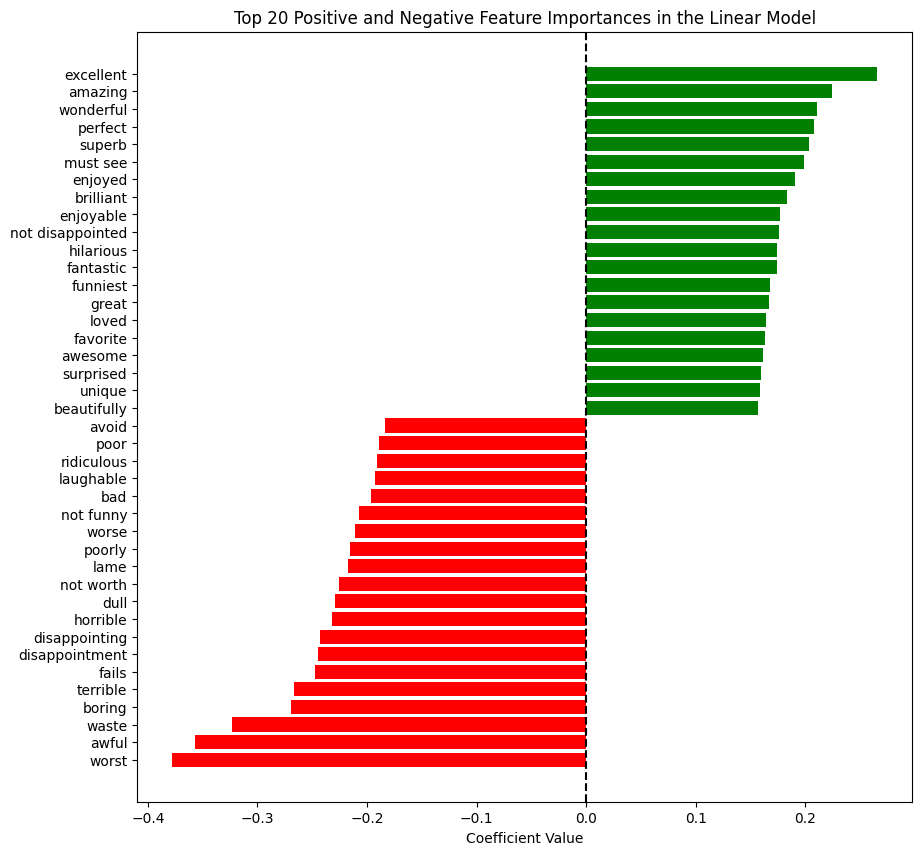

In [29]:
lsvc_model = LinearSVC(random_state=42, C=0.01, max_iter=5000).fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(lsvc_model, vectorizer_lemma_ngrams, top_n=20)

* When interpreting the feature importance plot, it's crucial to understand that it primarily shows how a specific feature influences the model's decision, assuming other features remain constant. This perspective is important for accurately assessing the impact of individual features.
* The presence of features such as "not funny" and "not disappointed" in the plot reinforces the decision to retain "not" in the corpus. These examples highlight the effectiveness of n-grams in capturing meaningful word combinations that significantly influence the classification results.
* Overall, the identified feature importances align well lexically, indicating that the model is recognizing relevant words and phrases that logically contribute to sentiment classification.

## Logistic Regression

In [30]:
log_reg_results = train_and_evaluate_model(LogisticRegression(random_state=42, max_iter=5000), datasets=prepared_data)

for key, value in log_reg_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, " 
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

Set: Lemmatization=True, Vectorization=ngrams, Training Time: 76.66 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8916, Test F1 Score: 0.8933
Set: Lemmatization=False, Vectorization=ngrams, Training Time: 75.28 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8911, Test F1 Score: 0.8929
Set: Lemmatization=True, Vectorization=tf-idf, Training Time: 0.52 seconds, Train Accuracy: 0.9224, Test Accuracy: 0.8864, Test F1 Score: 0.8880
Set: Lemmatization=False, Vectorization=tf-idf, Training Time: 0.32 seconds, Train Accuracy: 0.9146, Test Accuracy: 0.8862, Test F1 Score: 0.8878


* Logistic Regression demonstrates a slight improvement over the baseline LinearSVC model in terms of accuracy and F1 score.
* However, Logistic Regression requires more time for training, particularly noticeable with the dataset vectorized using n-grams, where training duration exceeded that of LinearSVC by more than tenfold. 
* Consistent with the observations from the LinearSVC model, lemmatization again leads to better performance compared to stemming. Similarly, n-grams vectorization yields higher accuracy but requires longer training times.

Moving forward, I aim to optimize the Logistic Regression model on the dataset that has shown the best results so far. The following hyperparameters will be the focus for tuning in the context of a binary classification task:
* Regularization parameter, `C`: A lower value denotes higher regularization. The standard setting is 1.0.
* Algorithm to use in the optimization problem, `solver`: The default is `lbfgs`. However, for large, sparse datasets such as ours, `saga` is often preferred due to its efficiency.

In [31]:
def log_reg_gridsearch(X_train, y_train, X_test, y_test):
    param_grid = {
        'C': [1, 10, 100],
        'solver': ['saga', 'lbfgs']
    }
    log_reg = LogisticRegression(random_state=42, max_iter=5000)
    perform_gridsearch(log_reg, param_grid, X_train, y_train, X_test, y_test)

In [32]:
log_reg_gridsearch(X_train_lemma_ngrams, y_train_lemma_ngrams, X_test_lemma_ngrams, y_test_lemma_ngrams)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 100, 'solver': 'saga'}
Best cross-validation accuracy: 0.8897
Accuracy for fold 1: 0.8916
Accuracy for fold 2: 0.8798
Accuracy for fold 3: 0.8988
Accuracy for fold 4: 0.8840
Accuracy for fold 5: 0.8941
Test Accuracy: 0.8916, Test F1 Score: 0.8932
Test Precision: 0.8828, Test Recall: 0.9039
Test AUC ROC score: 0.9544
Confusion Matrix:
[[3483  478]
 [ 383 3602]]


* The hyperparameter tuning process for Logistic Regression was considerably time-consuming, taking about an hour. This duration was notably longer than the tuning time for the LinearSVC model, even though it involved 10 fewer fits compared to the LinearSVC's tuning setup.
* The optimal configuration identified for the Logistic Regression model included a combination of weaker regularization and the 'saga' solver. Interestingly, despite these adjustments, there was no significant change in the model's accuracy on the test (validation) set.

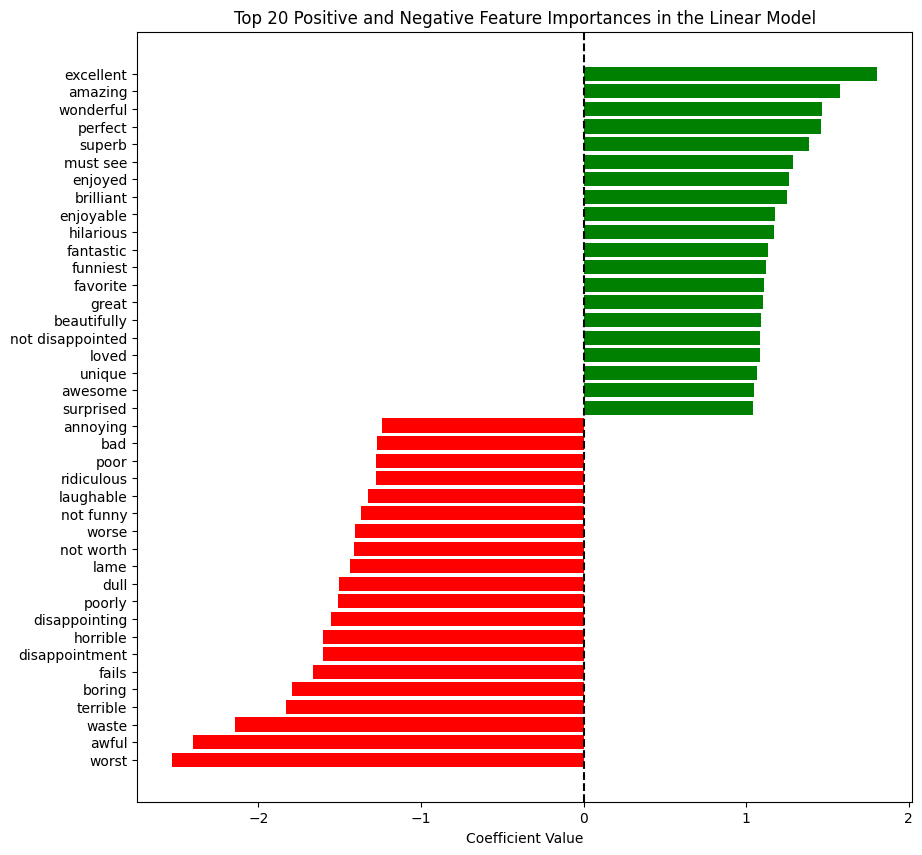

In [33]:
logreg_model = LogisticRegression(random_state=42, C=100, max_iter=5000, solver='saga').fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(logreg_model, vectorizer_lemma_ngrams, top_n=20)

The analysis of the top 20 important features in the Logistic Regression model reveals a notable similarity to those identified in the LinearSVC model. This consistency further validates the relevance of these features in sentiment classification across different modeling techniques.

## Random Forest

In [34]:
rf_results = train_and_evaluate_model(RandomForestClassifier(random_state=42), datasets=prepared_data)

for key, value in rf_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, "
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

Set: Lemmatization=True, Vectorization=ngrams, Training Time: 636.27 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8574, Test F1 Score: 0.8608
Set: Lemmatization=False, Vectorization=ngrams, Training Time: 598.90 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8541, Test F1 Score: 0.8610
Set: Lemmatization=True, Vectorization=tf-idf, Training Time: 17.48 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8529, Test F1 Score: 0.8543
Set: Lemmatization=False, Vectorization=tf-idf, Training Time: 16.61 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8460, Test F1 Score: 0.8473


So far, the Random Forest algorithm has demonstrated the least favorable performance in this project, both in terms of accuracy and training efficiency. Its training time significantly exceeds that of the LinearSVC model, being more than 100 times longer. Given this extensive training duration, a comprehensive hyperparameter tuning session, even with only two hyperparameters each having two values, is estimated to require around 4 hours. Consequently, hyperparameter tuning for the Random Forest model will not be pursued.

The observed lower accuracy of the Random Forest model can be partially attributed to the inherent nature of the dataset. As a tree-based method, Random Forest does not typically benefit from sparse datasets. In such scenarios, many decision tree splits may prove uninformative, particularly when they involve assessing features that predominantly contain zero values. Additionally, the high dimensionality and sparsity of text data present substantial challenges. Random Forest's effectiveness tends to decrease with an increase in feature count, especially when many features are less informative for predicting the target variable. This explains its underperformance in our high-dimensional, sparse text dataset.

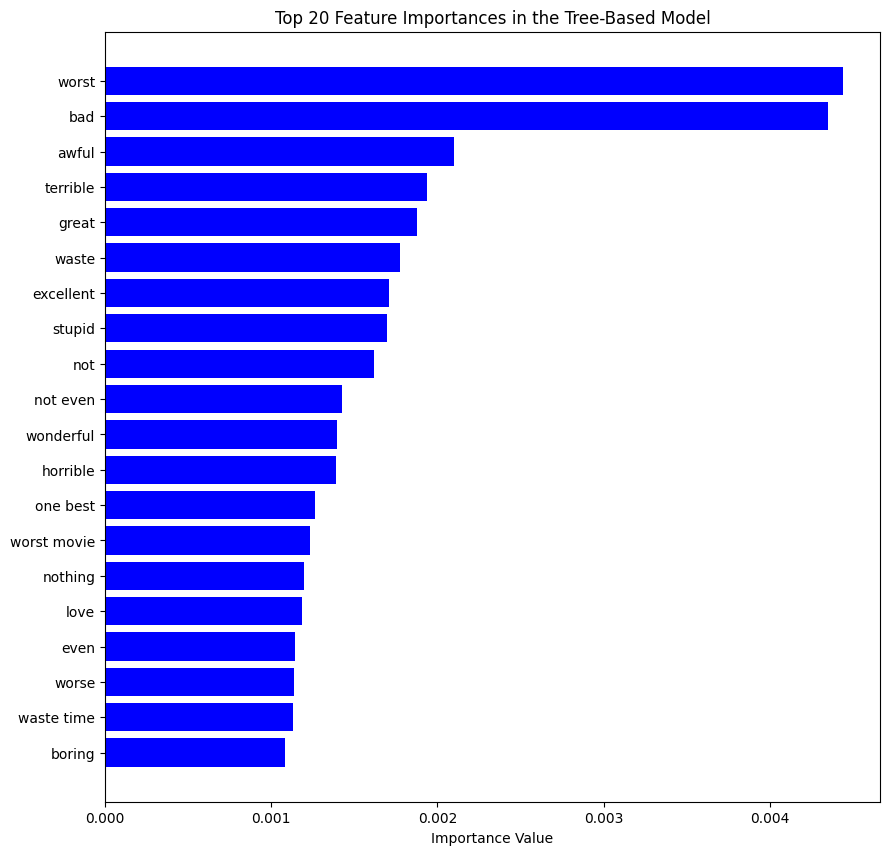

In [35]:
rf_model = RandomForestClassifier(random_state=42).fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(rf_model, vectorizer_lemma_ngrams, top_n=20)

* In linear models, coefficients can be either negative or positive, reflecting the direction of their influence on the outcome. On the other hand, feature importances in tree-based models, such as Random Forest, are always non-negative and do not signify directional influence. Consequently, the feature importance plot presented here can only highlight the most influential features, as it does not distinguish between positive and negative impacts.
* The analysis suggests that negative adjectives like "worst," "bad," and "awful" are predominantly driving the decision-making in this model. This observation aligns with the expectation that such words would have a significant impact in sentiment analysis, especially in the context of negative sentiment classification.

## CatBoost

In [41]:
cb_results = train_and_evaluate_model(CatBoostClassifier(random_state=42, verbose=False), datasets=prepared_data)

for key, value in cb_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, "
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

Set: Lemmatization=True, Vectorization=ngrams, Training Time: 2317.67 seconds, Train Accuracy: 0.9105, Test Accuracy: 0.8724, Test F1 Score: 0.8753
Set: Lemmatization=False, Vectorization=ngrams, Training Time: 2223.59 seconds, Train Accuracy: 0.9105, Test Accuracy: 0.8714, Test F1 Score: 0.8745
Set: Lemmatization=True, Vectorization=tf-idf, Training Time: 106.22 seconds, Train Accuracy: 0.9218, Test Accuracy: 0.8674, Test F1 Score: 0.8700
Set: Lemmatization=False, Vectorization=tf-idf, Training Time: 87.43 seconds, Train Accuracy: 0.9207, Test Accuracy: 0.8637, Test F1 Score: 0.8668


* CatBoost models required the longest training times among the algorithms tested. Given this, along with the inherent characteristic of CatBoost requiring less hyperparameter tuning, I will not pursue further tuning for these models.
* In terms of accuracy, CatBoost models exhibit better performance compared to Random Forest models. This improvement is likely partially attributable to CatBoost's inherent regularization, as evidenced by the training accuracies being lower than 1 across all variations of the model.
* Despite these advantages, the LinearSVC and Logistic Regression models still surpass CatBoost in overall performance.


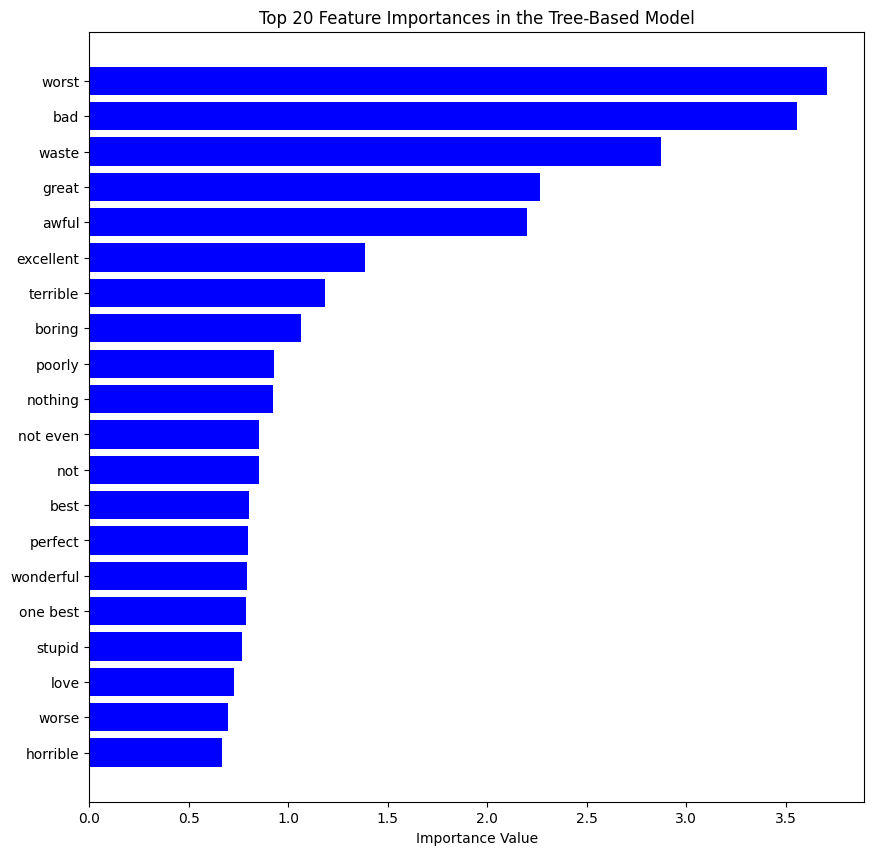

In [38]:
catboost_model = CatBoostClassifier(random_state=42, verbose=False).fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(catboost_model, vectorizer_lemma_ngrams, top_n=20)

Similar to the Random Forest model, the CatBoost model's classification decisions are predominantly influenced by negative adjectives. This pattern further supports the significance of these types of words in sentiment analysis.

## Model Choice

* A consistent trend observed throughout this analysis is the superior performance of lemmatization over stemming, and n-grams vectorization over TF-IDF, although at the expense of increased training time. Consequently, the lemmatized dataset with n-grams vectorization emerged as the preferred choice.
* Among the four machine learning algorithms evaluated, Logistic Regression and Linear SVC not only yielded the best results but also demonstrated the quickest training and tuning times.
* The tuned LinearSVC model, in particular, achieved the highest test (validation) accuracy at 0.8928, along with impressive metrics in other areas. Its training efficiency — being ten times faster than Logistic Regression on a lemmatized n-grams vectorized dataset — further backs its position as the optimal model for this project.
* For future endeavors to enhance accuracy, I recommend exploring additional preprocessing steps like spell-checking, experimenting with different libraries, and considering advanced deep learning methods such as RNNs and transformers. This study, constrained by time and hardware limitations, focused solely on traditional machine learning models.

# Appendix <a id="appendix-1"></a>

In this experimentation section, I aim to refine the data preprocessing steps to enhance the performance of the best-performing model by removing the words "movie" and "film". These terms are domain-specific and uniformly highly prevalent across both positive and negative sentiments. By excluding them from the corpus, we can assess whether this adjustment leads to any significant improvements in model performance.

In [39]:
class TextPreprocessor:
    def __init__(self, use_lemmatization=True, vectorization_type=None):
        self.use_lemmatization = use_lemmatization
        self.vectorization_type = vectorization_type
        self.stop_words = set(stopwords.words('english')).union({'movie', 'movies', 'film', 'films'}) - {'not'}
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if not use_lemmatization else None
        self.vectorizer = None
        self.rare_words = None
        self.contraction_mapping = {
            r"\bdidn't\b": "did not", r"\bdon't\b": "do not",
            r"\bwasn't\b": "was not", r"\bisn't\b": "is not",
            r"\bweren't\b": "were not", r"\bare't\b": "are not",
            r"\bwouldn't\b": "would not", r"\bwon't\b": "will not",
            r"\bcouldn't\b": "could not", r"\bcan't\b": "can not",
            r"\bain't\b": "am not", r"\bdoesn't\b": "does not",
            r"\bshouldn't\b": "should not", r"\bhadn't\b": "had not",
            r"\bhaven't\b": "have not", r"\bhasn't\b": "has not",
            r"\bmustn't\b": "must not"
        }

    def preprocess(self, data, fit_vectorizer=False):
        if 'sentiment' in data.columns:
            y = data['sentiment'].map({'negative': 0, 'positive': 1})
        else:
            y = None
        
        if self.rare_words is None:
            self._calculate_rare_words(data['review'])

        X_cleaned = data['review'].apply(self._clean_text)

        if self.vectorization_type and fit_vectorizer:
            self.vectorizer = self._get_vectorizer()
            X_vectorized = self.vectorizer.fit_transform(X_cleaned)
        elif self.vectorization_type:
            X_vectorized = self.vectorizer.transform(X_cleaned)
        else:
            X_vectorized = X_cleaned

        return X_vectorized, y, self.vectorizer if fit_vectorizer else None

    def _get_vectorizer(self):
        if self.vectorization_type.lower() == 'ngrams':
            return CountVectorizer(ngram_range=(1, 3), stop_words=list(self.stop_words))
        elif self.vectorization_type.lower() == 'tf-idf':
            return TfidfVectorizer(stop_words=list(self.stop_words))
        else:
            raise ValueError("Invalid vectorization type specified.")

    def _initial_preprocess(self, text):
        for contraction, expanded in self.contraction_mapping.items():
            text = re.sub(contraction, expanded, text, flags=re.IGNORECASE)
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"(n't|'d|'ll|'m|'re|'s|'ve|')", '', text, flags=re.IGNORECASE)
        tokens = word_tokenize(text)
        tokens = [word for word, pos in pos_tag(tokens) if pos not in ['NNP', 'NNPS']]
        tokens = [re.sub(r'\W+', ' ', word) for word in tokens if not word.isnumeric()]
        return [word.lower() for word in tokens]

    def _calculate_rare_words(self, reviews):
        all_words = [word for review in reviews for word in self._initial_preprocess(review)]
        word_counts = Counter(all_words)
        self.rare_words = {word for word, count in word_counts.items() if count == 1}

    def _clean_text(self, text):
        tokens = self._initial_preprocess(text)
        tokens = [word for word in tokens if word not in self.rare_words and word not in self.stop_words and len(word) > 2]

        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        else:
            tokens = [self.stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)
    
preprocessor = TextPreprocessor(use_lemmatization=True, vectorization_type='ngrams')
X_train, y_train, _ = preprocessor.preprocess(train, fit_vectorizer=True)
X_test, y_test, _ = preprocessor.preprocess(test, fit_vectorizer=False)
model = LinearSVC(random_state=42, C=0.01, max_iter=5000).fit(X_train, y_train)
print(f'Accuracy of the LinearSVC model after removing words "movie" and "film": {model.score(X_test, y_test): .4f}')

Accuracy of the LinearSVC model after removing words "movie" and "film":  0.8913


Interestingly, the removal of the words "movie" and "film" from the corpus resulted in a slight decrease in accuracy. This outcome suggests that their presence might have been contributing some value to the model's ability to differentiate sentiments.

Earlier during the preprocessing stage, we also saw that some of the most common words are stop words like "would", "could", and "one". These words are not part of the NLTK's stop-words list, which explains why they weren't removed initially. However, they are included in the SpaCy stop-words library. To potentially enhance the quality of the dataset, I will merge the stop-word lists from both NLTK and SpaCy for this project. This combined approach aims to create a more comprehensive stop-word list and see if it further refines the model's performance.

In [40]:
import spacy

spacy_stop_words = spacy.load('en_core_web_sm').Defaults.stop_words

class TextPreprocessor:
    def __init__(self, use_lemmatization=True, vectorization_type=None):
        self.use_lemmatization = use_lemmatization
        self.vectorization_type = vectorization_type
        self.stop_words = set(stopwords.words('english')).union(spacy_stop_words) - {'not'}
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if not use_lemmatization else None
        self.vectorizer = None
        self.rare_words = None
        self.contraction_mapping = {
            r"\bdidn't\b": "did not", r"\bdon't\b": "do not",
            r"\bwasn't\b": "was not", r"\bisn't\b": "is not",
            r"\bweren't\b": "were not", r"\bare't\b": "are not",
            r"\bwouldn't\b": "would not", r"\bwon't\b": "will not",
            r"\bcouldn't\b": "could not", r"\bcan't\b": "can not",
            r"\bain't\b": "am not", r"\bdoesn't\b": "does not",
            r"\bshouldn't\b": "should not", r"\bhadn't\b": "had not",
            r"\bhaven't\b": "have not", r"\bhasn't\b": "has not",
            r"\bmustn't\b": "must not"
        }

    def preprocess(self, data, fit_vectorizer=False):
        if 'sentiment' in data.columns:
            y = data['sentiment'].map({'negative': 0, 'positive': 1})
        else:
            y = None
        
        if self.rare_words is None:
            self._calculate_rare_words(data['review'])

        X_cleaned = data['review'].apply(self._clean_text)

        if self.vectorization_type and fit_vectorizer:
            self.vectorizer = self._get_vectorizer()
            X_vectorized = self.vectorizer.fit_transform(X_cleaned)
        elif self.vectorization_type:
            X_vectorized = self.vectorizer.transform(X_cleaned)
        else:
            X_vectorized = X_cleaned

        return X_vectorized, y, self.vectorizer if fit_vectorizer else None

    def _get_vectorizer(self):
        if self.vectorization_type.lower() == 'ngrams':
            return CountVectorizer(ngram_range=(1, 3), stop_words=list(self.stop_words))
        elif self.vectorization_type.lower() == 'tf-idf':
            return TfidfVectorizer(stop_words=list(self.stop_words))
        else:
            raise ValueError("Invalid vectorization type specified.")

    def _initial_preprocess(self, text):
        for contraction, expanded in self.contraction_mapping.items():
            text = re.sub(contraction, expanded, text, flags=re.IGNORECASE)
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"(n't|'d|'ll|'m|'re|'s|'ve|')", '', text, flags=re.IGNORECASE)
        tokens = word_tokenize(text)
        tokens = [word for word, pos in pos_tag(tokens) if pos not in ['NNP', 'NNPS']]
        tokens = [re.sub(r'\W+', ' ', word) for word in tokens if not word.isnumeric()]
        return [word.lower() for word in tokens]

    def _calculate_rare_words(self, reviews):
        all_words = [word for review in reviews for word in self._initial_preprocess(review)]
        word_counts = Counter(all_words)
        self.rare_words = {word for word, count in word_counts.items() if count == 1}

    def _clean_text(self, text):
        tokens = self._initial_preprocess(text)
        tokens = [word for word in tokens if word not in self.rare_words and word not in self.stop_words and len(word) > 2]

        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        else:
            tokens = [self.stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)
    
preprocessor = TextPreprocessor(use_lemmatization=True, vectorization_type='ngrams')
X_train, y_train, _ = preprocessor.preprocess(train, fit_vectorizer=True)
X_test, y_test, _ = preprocessor.preprocess(test, fit_vectorizer=False)
model = LinearSVC(random_state=42, C=0.01, max_iter=5000).fit(X_train, y_train)
print(f'Accuracy of the LinearSVC model after removing stop words from SpaCy: {model.score(X_test, y_test): .4f}')

Accuracy of the LinearSVC model after removing stop words from SpaCy:  0.8865


The expansion of the stop words list, incorporating words from both NLTK and SpaCy libraries, did not yield an improvement in the model's accuracy. Given these results, I will maintain the existing preprocessing pipeline as it currently stands.